# Generate experiment graphs

In [91]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## Read data from events file

In [99]:
def pandas_from_tf_events(path):
    events = [e for e in tf.train.summary_iterator(str(path))]
    
    t0 = events[0].wall_time
    
    def event_to_dict(event):
        summary = event.summary.value
        
        if len(summary) != 1:
            raise ValueError(f'Found event with summary of length {len(summary)}. Expected length is 1.')
        
        return {'time_minutes': (event.wall_time - t0) / 60.0, 'step': event.step, summary[0].tag: summary[0].simple_value}
        
    
    values_long = pd.DataFrame([
        event_to_dict(e) 
        for e in events 
        if len(e.summary.value) >= 1])
    
    return values_long.groupby('step').mean().sort_index().reset_index()

In [237]:
def plot_several_experiment_curves(
        experiments, title, x_value='steps', save_name=None, xlim=None):
    plt.figure(figsize=(10, 5))
    plt.title(title)
    if xlim:
        plt.xlim(xlim)
    ylim = (0, 40)
    plt.ylim(ylim)
    if x_value == 'steps':
        plt.xlabel('Number of steps')
        x_index = 'step'
    else:
        plt.xlabel('Time elapsed in minutes')
        x_index = 'time_minutes'
    plt.ylabel('Average reward (100 episodes)')
    
    colors = ['red', 'orange', 'green', 'blue', 'purple']
    
    for [title, path], color in zip(experiments, colors):
        event_df = pandas_from_tf_events(path)
        plt.plot(
            event_df[x_index], 
            event_df['rollout/ep_rew_mean'],
            label=title,
            color=color)
        episode_solutions = event_df[event_df['rollout/ep_rew_mean'] >= 30]
        first_solution = None if len(episode_solutions) == 0 else episode_solutions.iloc[0][x_index]
        
        if first_solution:
            plt.vlines(
                first_solution, 
                *ylim, 
                color=color, 
                linestyle='--', 
                linewidth=1,
                label=(
                    f'solved at step {int(first_solution)}' 
                    if x_value == 'steps' 
                    else f'solved in {first_solution:.2f} minutes'))
    
    plt.legend()
    if save_name:
        plt.savefig(Path('../artifacts') / (save_name + '.png'))
    plt.show()

## Pick the right architecture

In [238]:
experiments_arch = [
    ('64, 64, 64', '../experiments/ppo_large_64_64_64_lr_0_00005/tensorboard_logs/PPO_1/events.out.tfevents.1591453820.mariosk-G3-3590.12301.0'),
    ('64, 64, 64, 64', '../experiments/ppo_large_64_64_64_64_lr_0_00005/tensorboard_logs/PPO_1/events.out.tfevents.1591463713.mariosk-G3-3590.16647.0'),
    ('128, 128, 128', '../experiments/ppo_large_128_128_128_lr_0_00005_3M_steps/tensorboard_logs/PPO_1/events.out.tfevents.1591461232.mariosk-G3-3590.15785.0'),
    ('256, 256, 256', '../experiments/ppo_large_256_256_256_lr_0_00005/tensorboard_logs/PPO_1/events.out.tfevents.1591475349.mariosk-G3-3590.19467.0'),
]

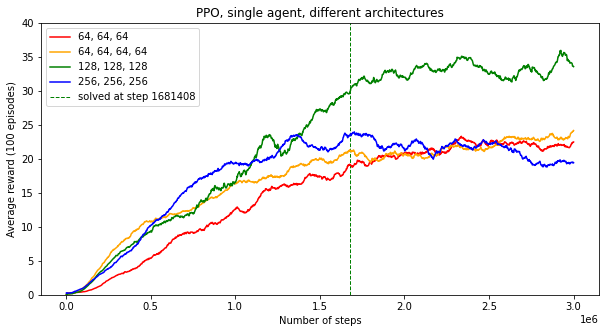

In [239]:
plot_several_experiment_curves(
    experiments_arch, 
    'PPO, single agent, different architectures',
    save_name='architecture_search')

## PPO - multiple agents

In [240]:
experiments_ppo = [
    ('lr = 0.0001', '../experiments/ppo_multi_agent_lr_0_0001/tensorboard_logs/PPO_1/events.out.tfevents.1591554783.mariosk-G3-3590.29801.0'),
    ('lr = 0.0005', '../experiments/ppo_multi_agent_lr_0_0005/tensorboard_logs/PPO_2/events.out.tfevents.1591554797.mariosk-G3-3590.30148.0'),
    ('lr = 0.00003', '../experiments/ppo_multi_agent_lr_0_00003/tensorboard_logs/PPO_1/events.out.tfevents.1591561479.mariosk-G3-3590.10935.0'),
    ('lr = 0.00001', '../experiments/ppo_multi_agent_lr_0_00001/tensorboard_logs/PPO_1/events.out.tfevents.1591561481.mariosk-G3-3590.11079.0')
]

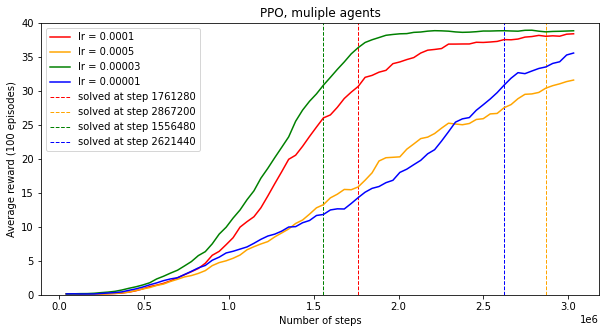

In [241]:
plot_several_experiment_curves(
    experiments_ppo, 
    'PPO, muliple agents',
    save_name='ppo_multi')

## A2C - multiple agents

In [242]:
experiments_a2c = [
    ('lr = 0.001', '../experiments/a2c_lr_0_001/tensorboard_logs/A2C_1/events.out.tfevents.1591697758.mariosk-G3-3590.10936.0'),
    ('lr = 0.0005', '../experiments/a2c_lr_0_0005/tensorboard_logs/A2C_1/events.out.tfevents.1591697723.mariosk-G3-3590.10723.0'),
    ('lr = 0.0003', '../experiments/a2c_lr_0_0003/tensorboard_logs/A2C_1/events.out.tfevents.1591700485.mariosk-G3-3590.15957.0'),
    ('lr = 0.0001', '../experiments/a2c_lr_0_0001/tensorboard_logs/A2C_1/events.out.tfevents.1591700422.mariosk-G3-3590.15702.0'),
    ('lr = 0.00005', '../experiments/a2c_lr_0_00005/tensorboard_logs/A2C_1/events.out.tfevents.1591701798.mariosk-G3-3590.19701.0'),
    ('lr = 0.00003', '../experiments/a2c_lr_0_00003/tensorboard_logs/A2C_1/events.out.tfevents.1591701817.mariosk-G3-3590.19879.0')
]

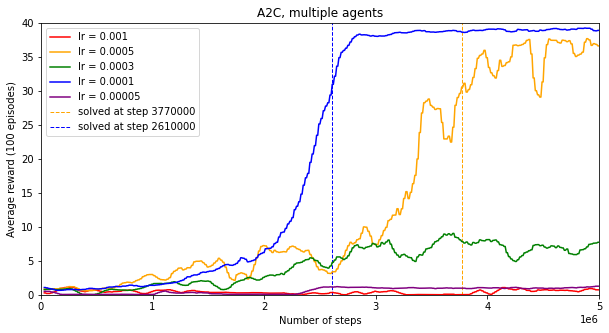

In [243]:
plot_several_experiment_curves(
    experiments_a2c, 
    'A2C, multiple agents',
    save_name='a2c_multi', 
    xlim=(0, 5e6))

## TD3 - single agent

In [244]:
experiments_td3 = [
    ('lr = 0.003', '../experiments/td3_0_003/tensorboard_logs/TD3_1/events.out.tfevents.1591866780.mariosk-G3-3590.8049.0'),
    ('lr = 0.001', '../experiments/td3_0_001/tensorboard_logs/TD3_1/events.out.tfevents.1591866829.mariosk-G3-3590.8276.0'),
    ('lr = 0.0005', '../experiments/td3_0_0005/tensorboard_logs/TD3_2/events.out.tfevents.1591854307.mariosk-G3-3590.4085.0'),
    ('lr = 0.0003', '../experiments/td3_0_0003/tensorboard_logs/TD3_1/events.out.tfevents.1591854319.mariosk-G3-3590.4231.0'),
    ('lr = 0.0001', '../experiments/td3_0_0001/tensorboard_logs/TD3_2/events.out.tfevents.1591866767.mariosk-G3-3590.7883.0')
]

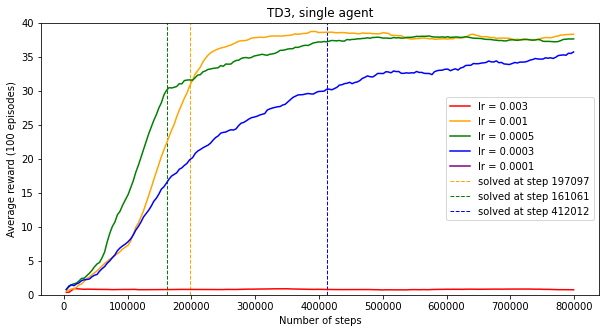

In [245]:
plot_several_experiment_curves(
    experiments_td3, 
    'TD3, single agent',
    save_name='td3_single')

## Compare steps

In [246]:
experiments_steps = [
    ('PPO multi, lr = 0.00003', '../experiments/ppo_multi_agent_lr_0_00003/tensorboard_logs/PPO_1/events.out.tfevents.1591561479.mariosk-G3-3590.10935.0'),
    ('A2C multi, lr = 0.0001', '../experiments/a2c_lr_0_0001/tensorboard_logs/A2C_1/events.out.tfevents.1591700422.mariosk-G3-3590.15702.0'),
    ('TD3 single, lr = 0.0005', '../experiments/td3_0_0005/tensorboard_logs/TD3_2/events.out.tfevents.1591854307.mariosk-G3-3590.4085.0')
]

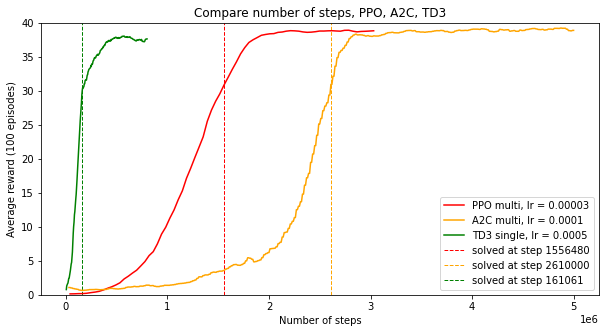

In [247]:
plot_several_experiment_curves(
    experiments_steps,
    'Compare number of steps, PPO, A2C, TD3',
    save_name='compare_steps')

## Compare stability

### PPO

In [248]:
experiments_ppo_stability = [
    ('run 1', '../experiments/ppo_multi_agent_lr_0_00003/tensorboard_logs/PPO_1/events.out.tfevents.1591561479.mariosk-G3-3590.10935.0'),
    ('run 2', '../experiments/ppo_multi_lr_0_00003_extra_1/tensorboard_logs/PPO_1/events.out.tfevents.1591727806.mariosk-G3-3590.4294.0'),
    ('run 3', '../experiments/ppo_multi_lr_0_00003_extra_2/tensorboard_logs/PPO_1/events.out.tfevents.1591727835.mariosk-G3-3590.4460.0'),
    ('run 4', '../experiments/ppo_multi_lr_0_00003_extra_3/tensorboard_logs/PPO_1/events.out.tfevents.1591732392.mariosk-G3-3590.8123.0'),
    ('run 5', '../experiments/ppo_multi_lr_0_00003_extra_4/tensorboard_logs/PPO_1/events.out.tfevents.1591732402.mariosk-G3-3590.8275.0')
]

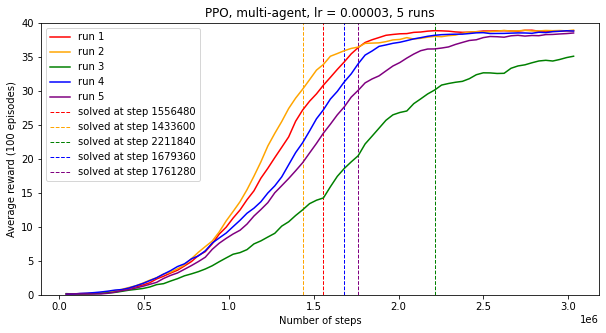

In [249]:
plot_several_experiment_curves(
    experiments_ppo_stability, 
    title='PPO, multi-agent, lr = 0.00003, 5 runs',
    save_name='ppo_stability')

### A2C

In [250]:
experiments_a2c_stability = [
    ('run 1', '../experiments/a2c_lr_0_0001/tensorboard_logs/A2C_1/events.out.tfevents.1591700422.mariosk-G3-3590.15702.0'),
    ('run 2', '../experiments/a2c_lr_0_0001_extra_1/tensorboard_logs/A2C_1/events.out.tfevents.1591718404.mariosk-G3-3590.17821.0'),
    ('run 3', '../experiments/a2c_lr_0_0001_extra_2/tensorboard_logs/A2C_1/events.out.tfevents.1591718418.mariosk-G3-3590.17996.0'),
    ('run 4', '../experiments/a2c_lr_0_0001_extra_3/tensorboard_logs/A2C_1/events.out.tfevents.1591722408.mariosk-G3-3590.30133.0'),
    ('run 5', '../experiments/a2c_lr_0_0001_extra_4/tensorboard_logs/A2C_1/events.out.tfevents.1591726369.mariosk-G3-3590.2220.0')
]

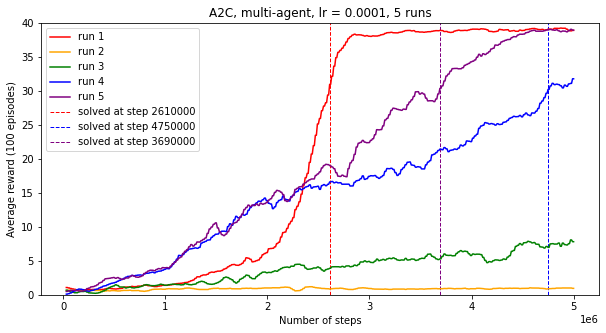

In [251]:
plot_several_experiment_curves(
    experiments_a2c_stability, 
    title='A2C, multi-agent, lr = 0.0001, 5 runs',
    save_name='a2c_stability')

### TD3

In [252]:
experiments_td3_stability = [
    ('run 1', '../experiments/td3_0_001/tensorboard_logs/TD3_1/events.out.tfevents.1591866829.mariosk-G3-3590.8276.0'),
    ('run 2', '../experiments/td3_0_001_extra_1/tensorboard_logs/TD3_1/events.out.tfevents.1591876066.mariosk-G3-3590.11426.0'),
    ('run 3', '../experiments/td3_0_001_extra_2/tensorboard_logs/TD3_1/events.out.tfevents.1591876088.mariosk-G3-3590.11576.0'),
    ('run 4', '../experiments/td3_0_001_extra_3/tensorboard_logs/TD3_1/events.out.tfevents.1591880388.mariosk-G3-3590.12917.0'),
    ('run 5', '../experiments/td3_0_001_extra_4/tensorboard_logs/TD3_1/events.out.tfevents.1591880394.mariosk-G3-3590.13066.0')
]

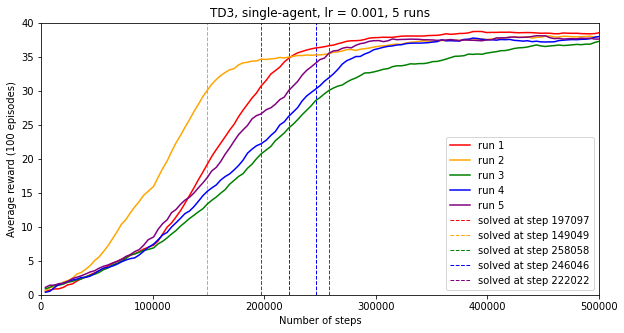

In [253]:
plot_several_experiment_curves(
    experiments_td3_stability, 
    title='TD3, single-agent, lr = 0.001, 5 runs',
    save_name='td3_stability',
    xlim=(0, 500000))

## Compare absolute time

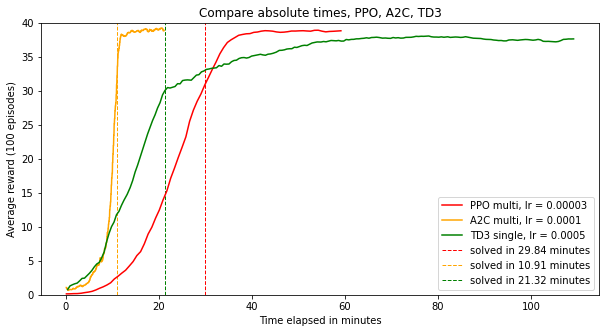

In [254]:
plot_several_experiment_curves(
    experiments_steps,
    'Compare absolute times, PPO, A2C, TD3',
    x_value='time',
    save_name='compare_time')